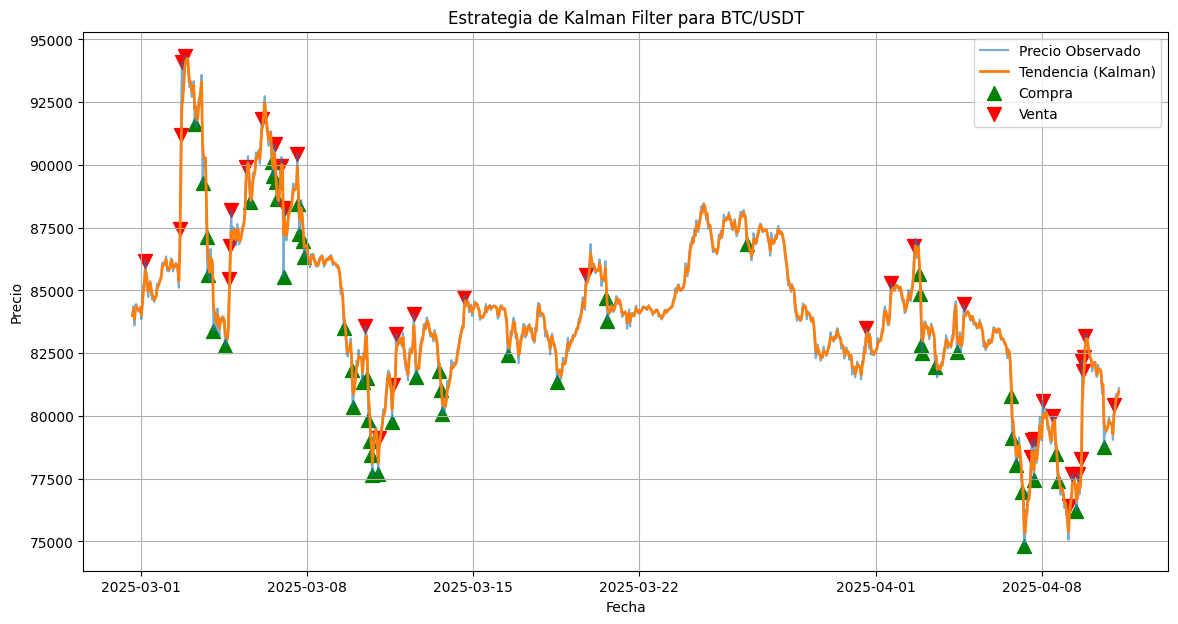

                        close  kalman_estimate     residuo   signal
timestamp                                                          
2025-02-28 15:00:00  84005.05     84005.050000    0.000000  neutral
2025-02-28 16:00:00  84363.69     84244.103551  119.586449  neutral
2025-02-28 17:00:00  83605.12     83844.748799 -239.628799  neutral
2025-02-28 18:00:00  84440.97     84213.836764  227.133236  neutral
2025-02-28 19:00:00  84449.99     84359.822323   90.167677  neutral
2025-02-28 20:00:00  84191.27     84255.647631  -64.377631  neutral
2025-02-28 21:00:00  84258.37     84257.330156    1.039844  neutral
2025-02-28 22:00:00  84149.98     84190.984062  -41.004062  neutral
2025-02-28 23:00:00  84349.94     84289.224245   60.715755  neutral
2025-03-01 00:00:00  83857.92     84022.663558 -164.743558  neutral
Historial de operaciones:
             timestamp action     price  position      capital
0  2025-03-03 06:00:00    BUY  91645.99  0.010912     0.000000
1  2025-03-04 17:00:00   SELL  8

In [21]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1. Obtención de datos históricos
# ----------------------------
exchange = ccxt.binance({'enableRateLimit': True})

def get_historical_data(symbol, timeframe='1h', limit=500):
    # La función fetch_ohlcv retorna [timestamp, open, high, low, close, volume]
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

# Obtener datos históricos para BTC/USDT
symbol = 'BTC/USDT'
data = get_historical_data(symbol, timeframe='1h', limit=1000)  # Por ejemplo, últimos 1000 periodos
prices = data['close']

# ----------------------------
# 2. Definición del filtro de Kalman
# ----------------------------
# Parámetros para el filtro de Kalman
Q = 0.001  # Varianza del proceso: controla la rapidez de adaptación de la tendencia
R = 0.001  # Varianza de observación: refleja la incertidumbre del precio observado

# Inicialización del filtro de Kalman:
# Se toma el primer precio como estimación inicial y una varianza inicial pequeña.
x_est = prices.iloc[0]
P = 1.0

# Arreglos para almacenar la estimación de la tendencia y los residuos
kalman_estimates = []
residuos = []

# Iterar sobre los precios y aplicar el filtro de Kalman
for price in prices:
    # Paso de predicción:
    x_pred = x_est         # Modelo de caminata aleatoria
    P_pred = P + Q

    # Ganancia de Kalman:
    K = P_pred / (P_pred + R)

    # Actualización:
    x_est = x_pred + K * (price - x_pred)
    P = (1 - K) * P_pred

    kalman_estimates.append(x_est)
    # Calcular el residuo (error entre precio observado y estimado)
    residuo = price - x_est
    residuos.append(residuo)

# Convertir las listas a una serie de Pandas (para facilitar el manejo y graficación)
kalman_series = pd.Series(kalman_estimates, index=prices.index)
residuo_series = pd.Series(residuos, index=prices.index)

# Calcular un umbral basado en la desviación estándar de los residuos
umbral_multiplicador = 1.5
umbral = umbral_multiplicador * residuo_series.std()

# ----------------------------
# 3. Generación de señales de trading basadas en el residuo
# ----------------------------
# Se usa la siguiente lógica:
# - Comprar ("buy") cuando el residuo es inferior a -umbral,
# - Vender ("sell") cuando el residuo es superior a umbral,
# - En caso contrario, se genera una señal neutral ("neutral").

signals = []
for residuo in residuo_series:
    if residuo < -umbral:
        signals.append('buy')
    elif residuo > umbral:
        signals.append('sell')
    else:
        signals.append('neutral')

# Agregar la serie de estimaciones, el residuo y la señal al DataFrame
data['kalman_estimate'] = kalman_series
data['residuo'] = residuo_series
data['signal'] = signals

# Para que la función de simulación trabaje con un nombre de columna uniforme, copiamos "signal" a "ensemble_signal"
data['ensemble_signal'] = data['signal']

# Visualización del modelo:
plt.figure(figsize=(14, 7))
plt.plot(data.index, prices, label='Precio Observado', alpha=0.6)
plt.plot(data.index, kalman_series, label='Tendencia (Kalman)', linewidth=2)
buy_signals = data[data['signal'] == 'buy']
sell_signals = data[data['signal'] == 'sell']
plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', s=100, label='Compra')
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', s=100, label='Venta')
plt.title(f'Estrategia de Kalman Filter para {symbol}')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

print(data[['close', 'kalman_estimate', 'residuo', 'signal']].head(10))


# ----------------------------
# 4. Función para simular el trading con una inversión de 1000 USD
# ----------------------------
def simulate_trading(data, initial_capital=1000):
    """
    Simula la estrategia de trading usando las señales 'ensemble_signal' del bot.

    Parámetros:
      data: DataFrame que incluye las columnas "close" y "ensemble_signal".
      initial_capital: Capital inicial en USD.

    Retorna:
      final_capital: Capital final tras la simulación.
      trades_log: DataFrame con el log de operaciones (timestamp, acción, precio, posición y capital).
    """
    capital = initial_capital  # Capital en USD
    position = 0.0             # Cantidad del activo en cartera (por ejemplo, BTC)
    in_position = False
    trades = []

    # Recorrer la serie de datos en orden cronológico
    for timestamp, row in data.iterrows():
        price = row['close']
        # Convertir la señal a formato numérico: "buy" -> 1, "sell" -> -1, "neutral" -> 0
        signal_str = row['ensemble_signal']
        if isinstance(signal_str, str):
            signal = 1 if signal_str.lower() == 'buy' else (-1 if signal_str.lower() == 'sell' else 0)
        else:
            signal = signal_str

        # Entrada: Si la señal es compra (1) y no se tiene posición
        if signal == 1 and not in_position:
            # Se compra usando todo el capital disponible
            position = capital / price
            capital = 0.0
            in_position = True
            trades.append({
                "timestamp": timestamp,
                "action": "BUY",
                "price": price,
                "position": position,
                "capital": capital
            })
        # Salida: Si la señal es venta (-1) y se tiene posición abierta
        elif signal == -1 and in_position:
            capital = position * price
            trades.append({
                "timestamp": timestamp,
                "action": "SELL",
                "price": price,
                "position": position,
                "capital": capital
            })
            position = 0.0
            in_position = False

    # Al final, si todavía existe una posición abierta, se vende al último precio
    if in_position:
        final_price = data['close'].iloc[-1]
        capital = position * final_price
        trades.append({
            "timestamp": data.index[-1],
            "action": "SELL (End)",
            "price": final_price,
            "position": position,
            "capital": capital
        })
        position = 0.0
        in_position = False

    final_capital = capital
    trades_log = pd.DataFrame(trades)
    return final_capital, trades_log

# ----------------------------
# 5. Simular trading y mostrar resultados
# ----------------------------
final_capital, trades_log = simulate_trading(data, initial_capital=1000)
print("Historial de operaciones:")
print(trades_log)
print(f"Capital final tras la simulación: ${final_capital:.2f}")


Mejores parámetros encontrados:
Q = 0.001
R = 0.001
RMSE = 242.7120502097733


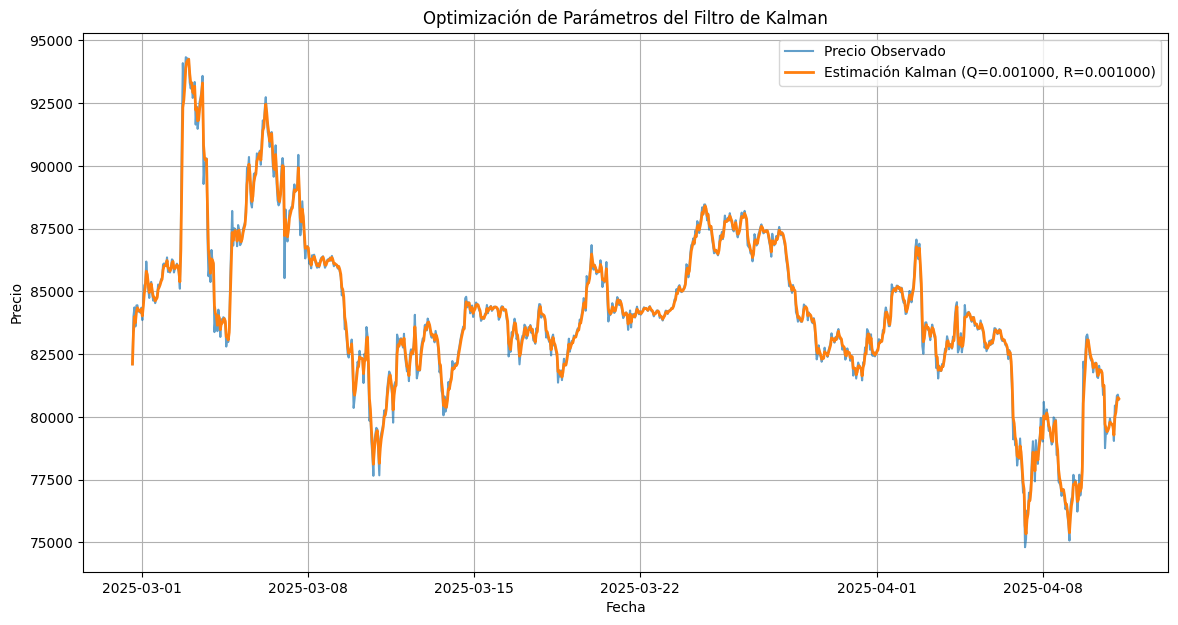

In [8]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Conexión al exchange (en este caso Binance)
exchange = ccxt.binance({
    'enableRateLimit': True,
})

# Función para obtener datos OHLCV históricos
def get_historical_data(symbol, timeframe='1h', limit=300):
    # La función fetch_ohlcv retorna [timestamp, open, high, low, close, volume]
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

# Obtener datos históricos para BTC/USDT
symbol = 'BTC/USDT'
data = get_historical_data(symbol, timeframe='1h', limit=1000)
prices = data['close'].values

# Función del filtro de Kalman
def kalman_filter(prices, Q, R, initial_est, initial_P):
    """
    Implementa un filtro de Kalman simple usando un modelo de caminata aleatoria.
    
    :param prices: Arreglo de precios observados.
    :param Q: Varianza del proceso (modelo).
    :param R: Varianza de la observación.
    :param initial_est: Valor inicial de la estimación.
    :param initial_P: Varianza inicial de la estimación.
    :return: Arreglo de estimaciones calculadas para cada punto.
    """
    x_est = initial_est
    P = initial_P
    estimates = []
    for price in prices:
        # Paso de predicción:
        x_pred = x_est         # Suponiendo modelo de caminata aleatoria
        P_pred = P + Q
        # Ganancia de Kalman:
        K = P_pred / (P_pred + R)
        # Actualización:
        x_est = x_pred + K * (price - x_pred)
        P = (1 - K) * P_pred
        estimates.append(x_est)
    return np.array(estimates)

# Función de error (en este ejemplo, se usa el RMSE)
def calcular_rmse(prices, estimates):
    return np.sqrt(mean_squared_error(prices, estimates))

# Definir rangos para los parámetros Q y R para la búsqueda en cuadrícula.
# Los rangos deben elegirse en función de la naturaleza del activo y la escala de los precios.
Q_values = np.linspace(0.00001, 0.001, num=30)
R_values = np.linspace(0.001, 0.05, num=30)

# Variables para almacenar el mejor ajuste
best_rmse = float('inf')
best_params = (None, None)

# Búsqueda en cuadrícula para optimizar Q y R
for Q in Q_values:
    for R in R_values:
        # Inicializar con el primer precio y una varianza inicial (por ejemplo, 1.0)
        estimates = kalman_filter(prices, Q, R, prices[0], 1.0)
        rmse = calcular_rmse(prices, estimates)
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (Q, R)

print("Mejores parámetros encontrados:")
print("Q =", best_params[0])
print("R =", best_params[1])
print("RMSE =", best_rmse)

# Aplicar el filtro con los parámetros óptimos
optimal_estimates = kalman_filter(prices, best_params[0], best_params[1], prices[0], 1.0)

# Agregar la estimación óptima al DataFrame para facilitar la visualización
data['Kalman_Estimate'] = optimal_estimates

# Graficar la serie de precios y la estimación obtenida con el filtro optimizado
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['close'], label='Precio Observado', alpha=0.7)
plt.plot(data.index, data['Kalman_Estimate'], label=f'Estimación Kalman (Q={best_params[0]:.6f}, R={best_params[1]:.6f})', linewidth=2)
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Optimización de Parámetros del Filtro de Kalman')
plt.legend()
plt.grid(True)
plt.show()


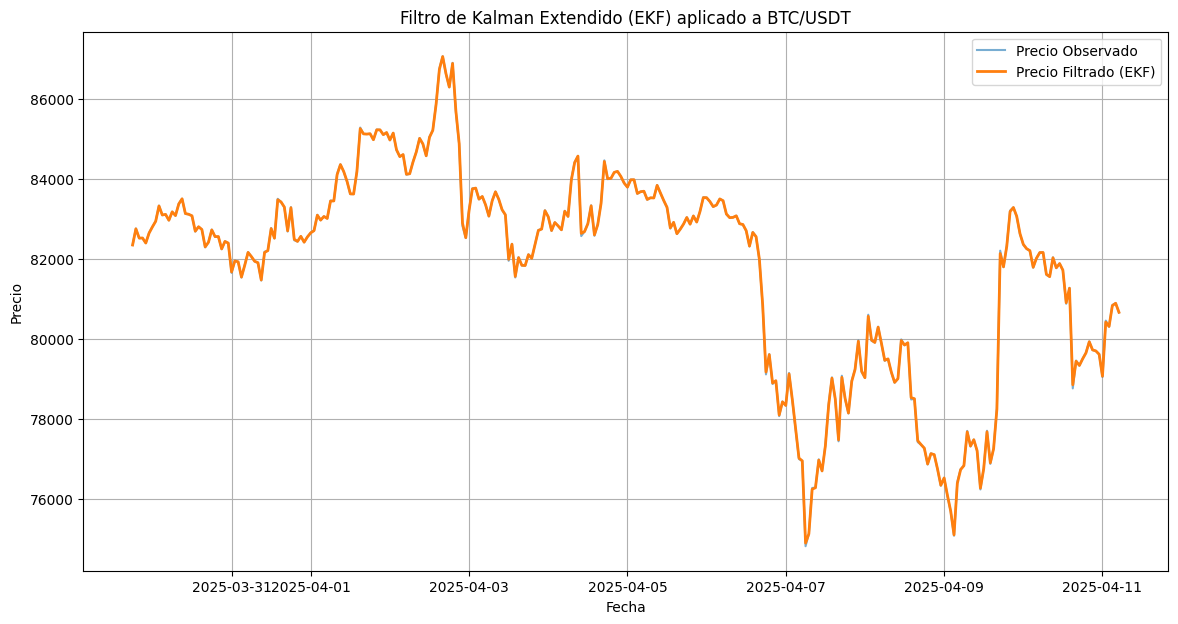

In [10]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Conexión al exchange: usamos Binance (asegúrate de tener habilitado rate limit)
exchange = ccxt.binance({'enableRateLimit': True})

def get_historical_data(symbol, timeframe='1h', limit=300):
    """
    Obtiene datos OHLCV históricos y devuelve un DataFrame de Pandas.
    """
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

# Obtener datos históricos para BTC/USDT
symbol = 'BTC/USDT'
data = get_historical_data(symbol, timeframe='1h', limit=300)
prices = data['close'].values

# Función de observación no lineal y su Jacobiano
def h(x):
    """Función de observación: h(x) = x^2."""
    return x**2

def H_jacobian(x):
    """Jacobiano (derivada) de la función de observación: dh/dx = 2x."""
    return 2 * x

def ekf_filter(prices, Q, R, initial_x, initial_P):
    """
    Implementa un filtro de Kalman Extendido (EKF) para un modelo no lineal.
    
    Modelo:
      Estado: x_t = x_{t-1} + w_t,   w_t ~ N(0, Q)
      Observación: y_t = x_t^2 + v_t,  v_t ~ N(0, R)
      
    Se estima x_t y se calcula el precio filtrado como x_t^2.
    
    :param prices: Arreglo de precios (observaciones).
    :param Q: Varianza del proceso.
    :param R: Varianza de la observación.
    :param initial_x: Estado inicial (se puede inicializar como sqrt del primer precio).
    :param initial_P: Varianza inicial del estado.
    :return: Arreglo de estimaciones de estado y arreglo de precios filtrados.
    """
    x_est = initial_x
    P = initial_P
    
    # Listas para almacenar la estimación del estado y el precio filtrado (x^2)
    state_estimates = []
    filtered_prices = []
    
    for y in prices:
        # Paso de predicción (modelo de caminata aleatoria):
        x_pred = x_est        # f(x) = x
        P_pred = P + Q
        
        # Función de observación no lineal:
        y_pred = h(x_pred)
        
        # Jacobiano de la función de observación:
        H = H_jacobian(x_pred)
        
        # Calcular innovación (residuo)
        innovation = y - y_pred
        
        # Covarianza de la innovación:
        S = H * P_pred * H + R
        
        # Ganancia de Kalman
        K = P_pred * H / S
        
        # Actualización del estado:
        x_est = x_pred + K * innovation
        
        # Actualización de la covarianza:
        P = (1 - K * H) * P_pred
        
        state_estimates.append(x_est)
        filtered_prices.append(h(x_est))
    
    return np.array(state_estimates), np.array(filtered_prices)

# Parámetros iniciales para el EKF
# Inicializamos el estado como la raíz cuadrada del primer precio observado (ya que y = x^2)
initial_x = np.sqrt(prices[0])
initial_P = 1.0

# Parámetros de ruido (ajusta Q y R según la escala y la volatilidad)
Q = 0.01    # Varianza del proceso
R = 100.0   # Varianza del ruido de observación

# Aplicar el EKF a la serie de precios
state_estimates, filtered_prices = ekf_filter(prices, Q, R, initial_x, initial_P)

# Agregar las estimaciones al DataFrame para facilitar la visualización
data['Filtered_Price'] = filtered_prices

# Visualización de resultados
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['close'], label='Precio Observado', alpha=0.6)
plt.plot(data.index, data['Filtered_Price'], label='Precio Filtrado (EKF)', linewidth=2)
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Filtro de Kalman Extendido (EKF) aplicado a BTC/USDT')
plt.legend()
plt.grid(True)
plt.show()


                        close  Filtered_Price       Residuo   Signal
timestamp                                                           
2025-03-29 18:00:00  82343.64    82343.640000 -1.455192e-11  neutral
2025-03-29 19:00:00  82758.40    82747.021208  1.137879e+01  neutral
2025-03-29 20:00:00  82511.17    82518.052821 -6.882821e+00  neutral
2025-03-29 21:00:00  82518.74    82518.720354  1.964579e-02  neutral
2025-03-29 22:00:00  82389.75    82393.484642 -3.734642e+00  neutral
2025-03-29 23:00:00  82648.54    82641.423787  7.116213e+00  neutral
2025-03-30 00:00:00  82799.73    82795.282496  4.447504e+00  neutral
2025-03-30 01:00:00  82941.13    82937.034400  4.095600e+00  neutral
2025-03-30 02:00:00  83330.00    83319.259051  1.074095e+01  neutral
2025-03-30 03:00:00  83088.81    83095.488060 -6.678060e+00  neutral


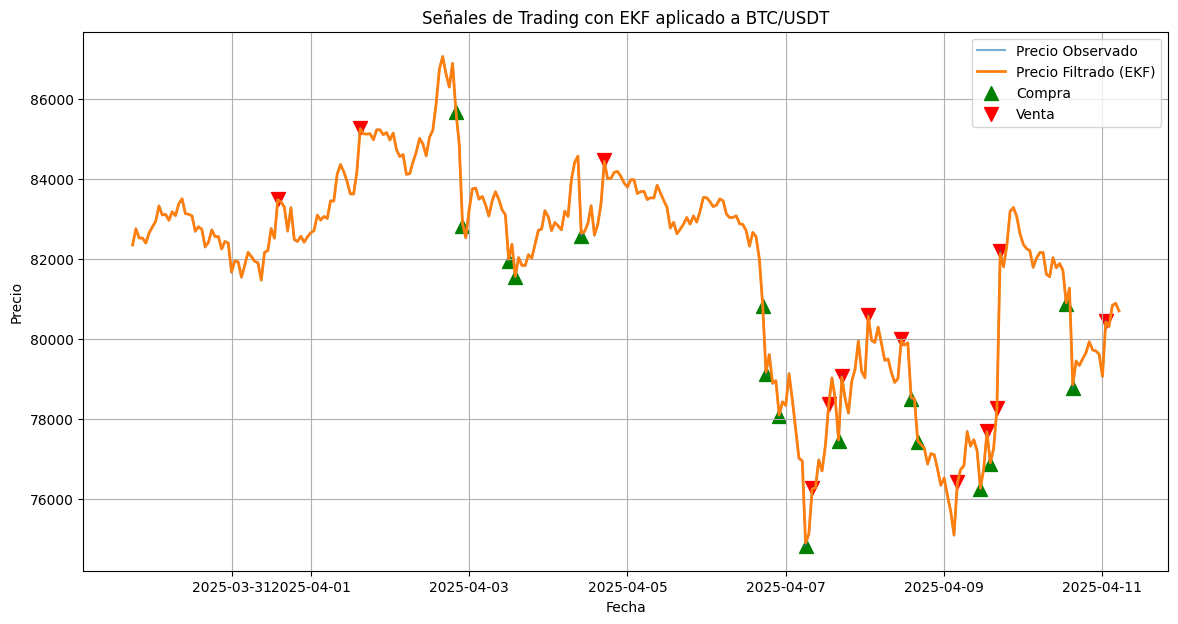

In [11]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Conexión al exchange: usamos Binance (asegúrate de tener habilitado rate limit)
exchange = ccxt.binance({'enableRateLimit': True})

def get_historical_data(symbol, timeframe='1h', limit=300):
    """
    Obtiene datos OHLCV históricos y devuelve un DataFrame de Pandas.
    """
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

# Obtener datos históricos para BTC/USDT
symbol = 'BTC/USDT'
data = get_historical_data(symbol, timeframe='1h', limit=300)
prices = data['close'].values

# Función de observación no lineal y su Jacobiano:
def h(x):
    """Función de observación: h(x) = x^2."""
    return x**2

def H_jacobian(x):
    """Jacobiano de h(x): dh/dx = 2x."""
    return 2 * x

def ekf_filter(prices, Q, R, initial_x, initial_P):
    """
    Implementa un Filtro de Kalman Extendido (EKF) para el modelo:
      Estado: x_t = x_{t-1} + w_t,   w_t ~ N(0, Q)
      Observación: y_t = x_t^2 + v_t,  v_t ~ N(0, R)
    
    Se estima el estado x y se calcula el precio filtrado como x^2.
    
    :param prices: Arreglo de precios observados.
    :param Q: Varianza del proceso.
    :param R: Varianza del ruido de observación.
    :param initial_x: Estado inicial.
    :param initial_P: Varianza inicial del estado.
    :return: Tuple (state_estimates, filtered_prices)
    """
    x_est = initial_x
    P = initial_P

    state_estimates = []
    filtered_prices = []
    
    for y in prices:
        # Predicción:
        x_pred = x_est        # Modelo: caminata aleatoria
        P_pred = P + Q

        # Función de observación no lineal:
        y_pred = h(x_pred)
        # Jacobiano:
        H = H_jacobian(x_pred)
        
        # Innovación:
        innovation = y - y_pred
        S = H * P_pred * H + R   # Covarianza de la innovación
        
        # Ganancia de Kalman:
        K = P_pred * H / S
        
        # Actualización:
        x_est = x_pred + K * innovation
        P = (1 - K * H) * P_pred
        
        state_estimates.append(x_est)
        filtered_prices.append(h(x_est))
        
    return np.array(state_estimates), np.array(filtered_prices)

# Parámetros iniciales para el EKF:
initial_x = np.sqrt(prices[0])  # Inicializamos como la raíz cuadrada del primer precio
initial_P = 1.0

# Parámetros de ruido; estos valores pueden ajustarse según la dinámica del activo.
Q = 0.01    # Varianza del proceso
R = 100.0   # Varianza del ruido de observación

# Aplicar el EKF a la serie de precios:
state_estimates, filtered_prices = ekf_filter(prices, Q, R, initial_x, initial_P)

# Agregar estimaciones al DataFrame:
data['Filtered_Price'] = filtered_prices

# Cálculo del residuo y definición de umbrales para señales:
data['Residuo'] = data['close'] - data['Filtered_Price']
# Definimos un umbral basado en un múltiplo de la desviación estándar del residuo:
umbral_multiplicador = 1.5
umbral = umbral_multiplicador * data['Residuo'].std()

# Generación de señales de trading:
# Se asigna "buy" si el precio observado es significativamente inferior a la estimación filtrada,
# "sell" si es significativamente superior y "neutral" en caso contrario.
def generar_senal(residuo, umbral):
    if residuo < -umbral:
        return 'buy'
    elif residuo > umbral:
        return 'sell'
    else:
        return 'neutral'

data['Signal'] = data['Residuo'].apply(lambda r: generar_senal(r, umbral))

# Mostrar las primeras filas para verificar las señales:
print(data[['close', 'Filtered_Price', 'Residuo', 'Signal']].head(10))

# Visualización de resultados y señales de trading:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['close'], label='Precio Observado', alpha=0.6)
plt.plot(data.index, data['Filtered_Price'], label='Precio Filtrado (EKF)', linewidth=2)

# Marcar señales de compra y venta:
buy_signals = data[data['Signal'] == 'buy']
sell_signals = data[data['Signal'] == 'sell']

plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', s=100, label='Compra')
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', s=100, label='Venta')

plt.title('Señales de Trading con EKF aplicado a BTC/USDT')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()


Report del Meta-Modelo:
              precision    recall  f1-score   support

           0       0.54      0.81      0.65        54
           1       0.47      0.20      0.28        46

    accuracy                           0.53       100
   macro avg       0.51      0.51      0.46       100
weighted avg       0.51      0.53      0.48       100



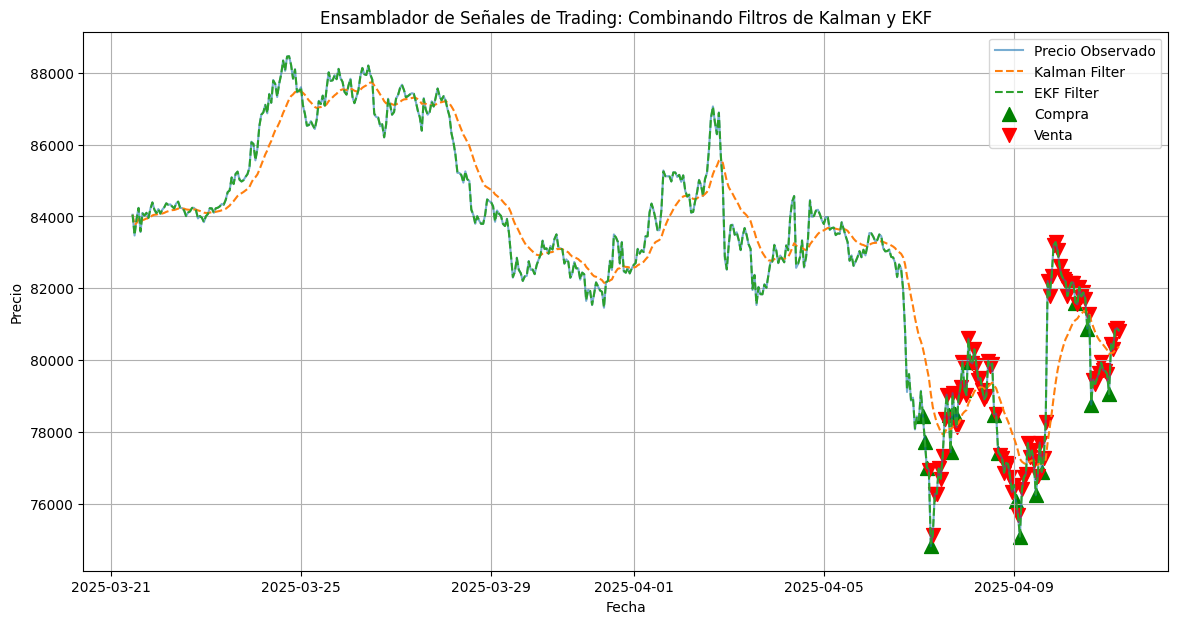

Historial de operaciones:
            timestamp      action     price  position      capital
0 2025-04-07 02:00:00         BUY  78447.42  0.012747     0.000000
1 2025-04-11 05:00:00  SELL (End)  80816.00  0.012747  1030.193217
Capital final tras la simulación: $1030.19


In [19]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# ----------------------------
# 1. Obtención de datos históricos
# ----------------------------
exchange = ccxt.binance({'enableRateLimit': True})

def get_historical_data(symbol, timeframe='1h', limit=500):
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

symbol = 'BTC/USDT'
data = get_historical_data(symbol, timeframe='1h', limit=500)
data = data[['close']]

# ----------------------------
# 2. Definición de los filtros
# ----------------------------
# Función del filtro de Kalman simple (modelo de caminata aleatoria)
def kalman_filter(prices, Q, R, initial_est, initial_P):
    x_est = initial_est
    P = initial_P
    estimates = []
    for price in prices:
        # Predicción:
        x_pred = x_est
        P_pred = P + Q
        
        # Ganancia de Kalman:
        K = P_pred / (P_pred + R)
        # Actualización:
        x_est = x_pred + K * (price - x_pred)
        P = (1 - K) * P_pred
        
        estimates.append(x_est)
    return np.array(estimates)

# Funciones para el filtro de Kalman Extendido (EKF)
# Se asume un modelo didáctico donde: 
#   Estado: x_t = x_{t-1} + w_t,    w_t ~ N(0, Q)
#   Observación: y_t = h(x_t) = x_t^2 + v_t,   v_t ~ N(0, R)
def h(x):
    return x**2

def H_jacobian(x):
    return 2 * x

def ekf_filter(prices, Q, R, initial_x, initial_P):
    x_est = initial_x
    P = initial_P
    state_estimates = []
    filtered_prices = []
    for y in prices:
        # Predicción (modelo de caminata aleatoria):
        x_pred = x_est
        P_pred = P + Q
        
        # Observación y su Jacobiano:
        y_pred = h(x_pred)
        H = H_jacobian(x_pred)
        
        # Innovación y su covarianza:
        innovation = y - y_pred
        S = H * P_pred * H + R
        
        # Ganancia de Kalman:
        K = P_pred * H / S
        
        # Actualización:
        x_est = x_pred + K * innovation
        P = (1 - K * H) * P_pred
        
        state_estimates.append(x_est)
        filtered_prices.append(h(x_est))
    return np.array(state_estimates), np.array(filtered_prices)

# ----------------------------
# 3. Aplicar ambos filtros a la serie de precios
# ----------------------------
prices = data['close'].values

# Parámetros para el filtro de Kalman simple:
kf_Q = 0.0001
kf_R = 0.01
initial_est = prices[0]
initial_P = 1.0

kalman_estimates = kalman_filter(prices, kf_Q, kf_R, initial_est, initial_P)

# Parámetros para el EKF:
# Inicializamos el estado del EKF como la raíz cuadrada del primer precio,
# porque el modelo es: y = x^2
ekf_Q = 0.01
ekf_R = 100.0
initial_x = np.sqrt(prices[0])
ekf_initial_P = 1.0

ekf_state, ekf_filtered = ekf_filter(prices, ekf_Q, ekf_R, initial_x, ekf_initial_P)

# Agregamos las estimaciones al DataFrame:
data['Kalman_Filter'] = kalman_estimates
data['EKF_Filter'] = ekf_filtered

# ----------------------------
# 4. Generar señales base a partir de los residuos
# ----------------------------
# Para cada modelo, calculamos el residuo: residuo = precio observado - precio filtrado

data['residuo_kf'] = data['close'] - data['Kalman_Filter']
data['residuo_ekf'] = data['close'] - data['EKF_Filter']

# Como ejemplo base, definimos una señal numérica en base a un umbral derivado
# del valor absoluto del residuo (puedes ajustar o incluir normalización)
def base_signal(residuo, threshold):
    if residuo > threshold:
        return -1    # Señal de venta (precio por encima del filtrado)
    elif residuo < -threshold:
        return 1     # Señal de compra (precio por debajo del filtrado)
    else:
        return 0     # Neutral

# Definir umbrales como un múltiplo de la desviación estándar de cada residuo
threshold_kf = 1.0 * data['residuo_kf'].std()
threshold_ekf = 1.0 * data['residuo_ekf'].std()

data['signal_kf'] = data['residuo_kf'].apply(lambda r: base_signal(r, threshold_kf))
data['signal_ekf'] = data['residuo_ekf'].apply(lambda r: base_signal(r, threshold_ekf))

# ----------------------------
# 5. Crear el target para el meta-modelo
# ----------------------------
# Una estrategia simple: target = 1 si el precio sube en el siguiente período, 0 en caso contrario
data['future_return'] = data['close'].shift(-1) - data['close']
data['target'] = data['future_return'].apply(lambda r: 1 if r > 0 else 0)

# Eliminamos la última fila (donde future_return es NaN)
data.dropna(inplace=True)

# ----------------------------
# 6. Preparar features y entrenar el meta-modelo (stacking)
# ----------------------------
# Las features base serán las señales de cada modelo (puedes también usar los residuos o combinaciones)
features = data[['signal_kf', 'signal_ekf']]
target = data['target']

# Para series temporales se recomienda no mezclar el orden;
# En este ejemplo se hará una separación sin shuffle.
split_idx = int(0.8 * len(data))
X_train = features.iloc[:split_idx]
X_test = features.iloc[split_idx:]
y_train = target.iloc[:split_idx]
y_test = target.iloc[split_idx:]

meta_model = LogisticRegression()
meta_model.fit(X_train, y_train)

# Predecir con el meta-modelo (la señal ensamblada final)
data.loc[X_test.index, 'ensemble_signal'] = meta_model.predict(X_test)

print("Report del Meta-Modelo:")
print(classification_report(y_test, meta_model.predict(X_test)))

# ----------------------------
# 7. Visualización final de señales
# ----------------------------
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['close'], label='Precio Observado', alpha=0.6)
plt.plot(data.index, data['Kalman_Filter'], label='Kalman Filter', linestyle='--')
plt.plot(data.index, data['EKF_Filter'], label='EKF Filter', linestyle='--')

# Marcar señales del ensamblador:
# En este ejemplo, consideramos:
#   - Señal 1: Buy
#   - Señal 0: Sell (o se podría interpretar como "no comprar")
buy_signals = data[(data['ensemble_signal'] == 1)]
sell_signals = data[(data['ensemble_signal'] == 0)]

plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', s=100, label='Compra')
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', s=100, label='Venta')

plt.title('Ensamblador de Señales de Trading: Combinando Filtros de Kalman y EKF')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()



# ----------------------------
# 8. Función para simular el trading con una inversión de 1000 USD
# ----------------------------
def simulate_trading(data, initial_capital=1000):
    """
    Simula la estrategia de trading usando las señales 'ensemble_signal' del bot.

    Parámetros:
      data: DataFrame que incluye las columnas "close" y "ensemble_signal".
      initial_capital: Capital inicial en USD.

    Retorna:
      final_capital: Capital final tras la simulación.
      trades_log: DataFrame con el log de operaciones (timestamp, acción, precio, posición y capital).
    """
    capital = initial_capital  # Capital en USD
    position = 0.0             # Cantidad de activo en cartera (por ejemplo, BTC)
    in_position = False
    trades = []

    # Recorrer la serie de datos en orden cronológico
    for timestamp, row in data.iterrows():
        price = row['close']
        signal = row['ensemble_signal']

        # Condición para entrada (compra)
        if signal == 1 and not in_position:
            # Comprar con todo el capital
            position = capital / price
            capital = 0.0
            in_position = True
            trades.append({
                "timestamp": timestamp,
                "action": "BUY",
                "price": price,
                "position": position,
                "capital": capital
            })

        # Condición para salida (venta)
        elif signal == -1 and in_position:
            capital = position * price
            trades.append({
                "timestamp": timestamp,
                "action": "SELL",
                "price": price,
                "position": position,
                "capital": capital
            })
            position = 0.0
            in_position = False

    # Al final, si todavía hay posición abierta, se vende al último precio
    if in_position:
        final_price = data['close'].iloc[-1]
        capital = position * final_price
        trades.append({
            "timestamp": data.index[-1],
            "action": "SELL (End)",
            "price": final_price,
            "position": position,
            "capital": capital
        })
        position = 0.0
        in_position = False

    final_capital = capital
    trades_log = pd.DataFrame(trades)
    return final_capital, trades_log

# ----------------------------
# 9. Simular trading y mostrar resultados
# ----------------------------
final_capital, trades_log = simulate_trading(data, initial_capital=1000)
print("Historial de operaciones:")
print(trades_log)
print(f"Capital final tras la simulación: ${final_capital:.2f}")



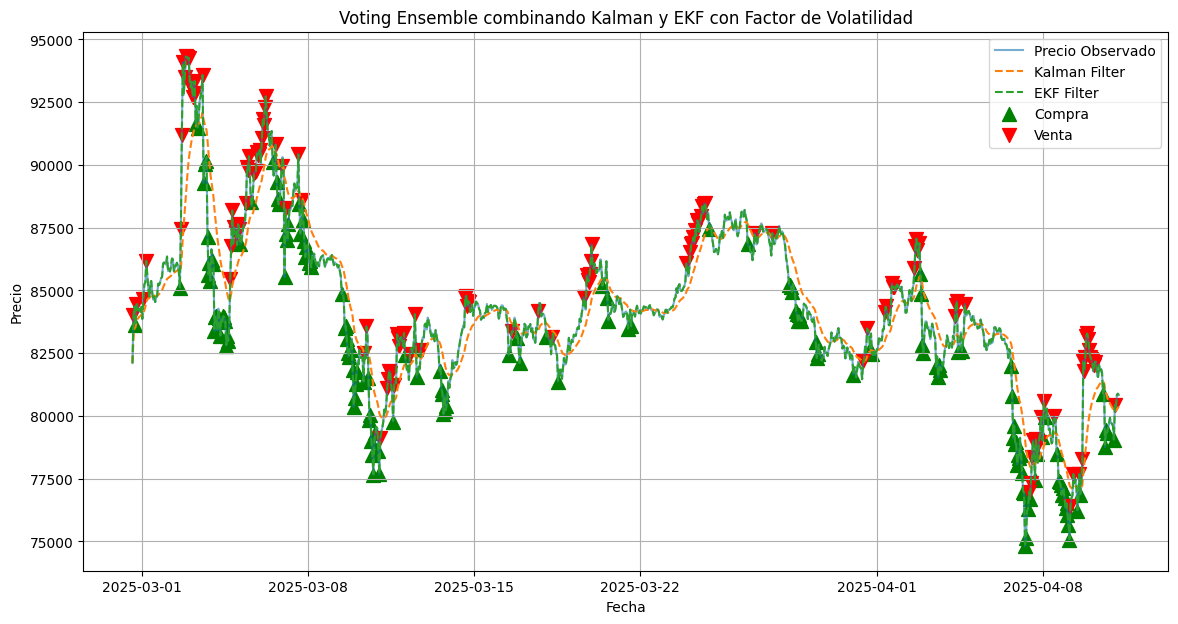

                        close  Kalman_Filter    EKF_Filter  signal_kf  \
timestamp                                                               
2025-04-10 20:00:00  79931.55   80497.670582  79923.319697          0   
2025-04-10 21:00:00  79714.52   80423.173444  79720.799907          0   
2025-04-10 22:00:00  79693.77   80353.788998  79694.570527          0   
2025-04-10 23:00:00  79607.30   80282.779290  79609.900810          0   
2025-04-11 00:00:00  79043.48   80164.891042  79061.180181          0   
2025-04-11 01:00:00  80452.72   80192.270749  80417.054471          0   
2025-04-11 02:00:00  80302.05   80202.713492  80305.456008          0   
2025-04-11 03:00:00  80842.99   80263.619745  80828.070151          0   
2025-04-11 04:00:00  80888.15   80323.028137  80886.409343          0   
2025-04-11 05:00:00  80829.23   80371.180549  80830.905293          0   

                     signal_ekf  volatilidad  peso_vol  ensemble_signal  
timestamp                                        

In [ ]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1. Obtención de datos históricos
# ----------------------------
exchange = ccxt.binance({'enableRateLimit': True})

def get_historical_data(symbol, timeframe='1h', limit=500):
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

symbol = 'BTC/USDT'
data = get_historical_data(symbol, timeframe='1h', limit=1000)
data = data[['close']]

# ----------------------------
# 2. Definición de los modelos base: Kalman y EKF
# ----------------------------
# --- Filtro de Kalman Simple (modelo de caminata aleatoria)
def kalman_filter(prices, Q, R, initial_est, initial_P):
    x_est = initial_est
    P = initial_P
    estimates = []
    for price in prices:
        # Predicción:
        x_pred = x_est
        P_pred = P + Q
        
        # Ganancia de Kalman:
        K = P_pred / (P_pred + R)
        # Actualización:
        x_est = x_pred + K * (price - x_pred)
        P = (1 - K) * P_pred
        
        estimates.append(x_est)
    return np.array(estimates)

# --- Filtro de Kalman Extendido (EKF)
# Se considera el modelo:
#   Estado: x_t = x_{t-1} + w_t,    w_t ~ N(0, Q)
#   Observación: y_t = h(x_t) = x_t^2 + v_t,   v_t ~ N(0, R)

def h(x):
    """Función de observación no lineal: h(x)=x^2"""
    return x**2

def H_jacobian(x):
    """Jacobiano de h(x): dh/dx = 2x"""
    return 2 * x

def ekf_filter(prices, Q, R, initial_x, initial_P):
    x_est = initial_x
    P = initial_P
    state_estimates = []
    filtered_prices = []
    for y in prices:
        # Predicción:
        x_pred = x_est  # caminata aleatoria
        P_pred = P + Q
        
        # Observación y Jacobiano
        y_pred = h(x_pred)
        H = H_jacobian(x_pred)
        
        # Innovación:
        innovation = y - y_pred
        S = H * P_pred * H + R
        
        # Ganancia de Kalman:
        K = P_pred * H / S
        
        # Actualización:
        x_est = x_pred + K * innovation
        P = (1 - K * H) * P_pred
        
        state_estimates.append(x_est)
        filtered_prices.append(h(x_est))
    return np.array(state_estimates), np.array(filtered_prices)

# ----------------------------
# 3. Aplicar los filtros a la serie de precios
# ----------------------------
prices = data['close'].values

# Parámetros para Kalman simple
kf_Q = 0.0001
kf_R = 0.01
initial_est = prices[0]
initial_P = 1.0
kalman_estimates = kalman_filter(prices, kf_Q, kf_R, initial_est, initial_P)

# Parámetros para EKF
ekf_Q = 0.01
ekf_R = 100.0
initial_x = np.sqrt(prices[0])  # dado que observamos y = x^2
ekf_initial_P = 1.0
ekf_state, ekf_filtered = ekf_filter(prices, ekf_Q, ekf_R, initial_x, ekf_initial_P)

data['Kalman_Filter'] = kalman_estimates
data['EKF_Filter'] = ekf_filtered

# ----------------------------
# 4. Generar señales base a partir de cada filtro
# ----------------------------
# Calculamos el residuo (error) entre el precio observado y la estimación filtrada
data['residuo_kf'] = data['close'] - data['Kalman_Filter']
data['residuo_ekf'] = data['close'] - data['EKF_Filter']

# Función para convertir el residuo a una señal:
# Si el residuo > threshold -> señal de venta (-1)
# Si el residuo < -threshold -> señal de compra (1)
# De lo contrario, neutral (0)
def base_signal(residuo, threshold):
    if residuo > threshold:
        return -1  # Venta
    elif residuo < -threshold:
        return 1   # Compra
    else:
        return 0   # Neutral

# Definir umbrales basados en la desviación estándar de cada residuo
threshold_kf = data['residuo_kf'].std()
threshold_ekf = data['residuo_ekf'].std()

data['signal_kf'] = data['residuo_kf'].apply(lambda r: base_signal(r, threshold_kf))
data['signal_ekf'] = data['residuo_ekf'].apply(lambda r: base_signal(r, threshold_ekf))

# ----------------------------
# 5. Incorporar un modelo de volatilidad
# ----------------------------
# Calculamos la volatilidad como la desviación estándar móvil (por ejemplo, en una ventana de 20 períodos)
data['volatilidad'] = data['close'].rolling(window=20).std()

# Definimos un umbral de volatilidad (por ejemplo, la mediana de la volatilidad)
vol_threshold = data['volatilidad'].median()

# Asignamos un factor de peso en función de la volatilidad:
# En baja volatilidad, usamos el peso 1; en alta volatilidad, usamos un peso menor (por ejemplo, 0.5)
def weight_factor(vol):
    return 1.0 if vol < vol_threshold else 0.5

data['peso_vol'] = data['volatilidad'].apply(weight_factor)

# ----------------------------
# 6. Voting ensemble: combinar las señales de ambos filtros ponderadas por el factor de volatilidad
# ----------------------------
# Calculamos el voto final: por ejemplo, la suma ponderada de las señales
# Si la suma es mayor que 0 -> señal de compra, menor que 0 -> señal de venta, igual a 0 -> neutral
data['voto_ensemble'] = (data['signal_kf'] + data['signal_ekf']) * data['peso_vol']

def final_signal(voto):
    if voto > 0:
        return 1    # Compra
    elif voto < 0:
        return -1   # Venta
    else:
        return 0    # Neutral

data['ensemble_signal'] = data['voto_ensemble'].apply(final_signal)

# ----------------------------
# 7. Visualización
# ----------------------------
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['close'], label='Precio Observado', alpha=0.6)
plt.plot(data.index, data['Kalman_Filter'], label='Kalman Filter', linestyle='--')
plt.plot(data.index, data['EKF_Filter'], label='EKF Filter', linestyle='--')

# Marcar señales finales
buy_signals = data[data['ensemble_signal'] == 1]
sell_signals = data[data['ensemble_signal'] == -1]

plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', s=100, label='Compra')
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', s=100, label='Venta')

plt.title('Voting Ensemble combinando Kalman y EKF con Factor de Volatilidad')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

# Imprimir algunas columnas relevantes
print(data[['close', 'Kalman_Filter', 'EKF_Filter', 'signal_kf', 'signal_ekf', 'volatilidad', 'peso_vol', 'ensemble_signal']].tail(10))


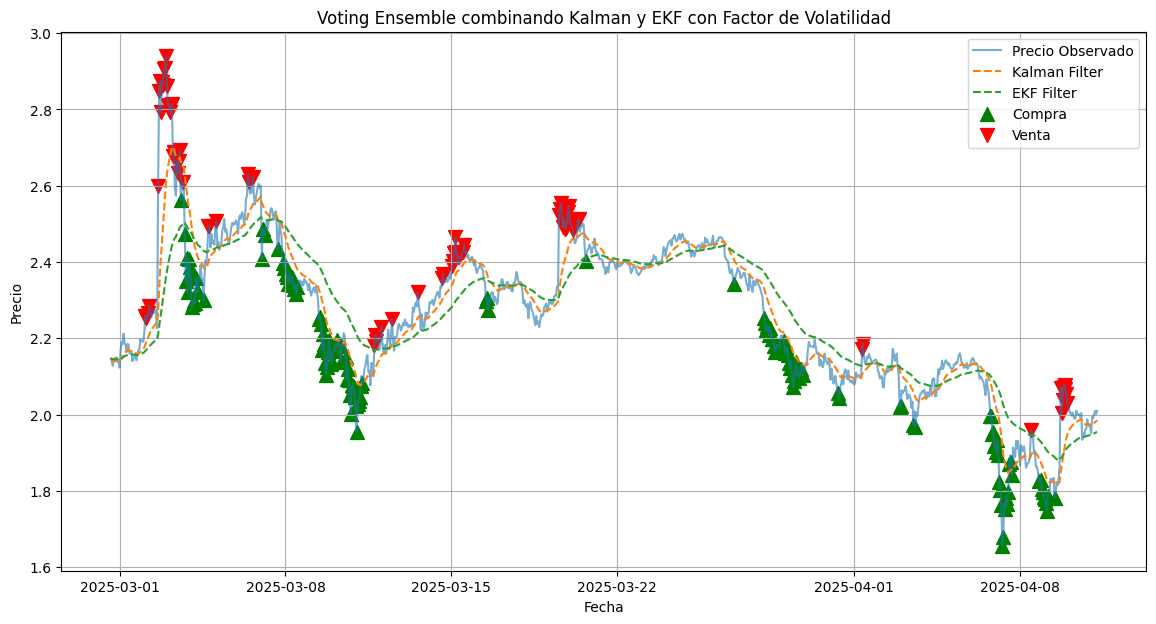

                      close  Kalman_Filter  EKF_Filter  signal_kf  signal_ekf  \
timestamp                                                                       
2025-04-10 21:00:00  1.9738       1.974662    1.945040          0           0   
2025-04-10 22:00:00  1.9694       1.974161    1.945713          0           0   
2025-04-10 23:00:00  1.9658       1.973366    1.946268          0           0   
2025-04-11 00:00:00  1.9514       1.971276    1.946410          0           0   
2025-04-11 01:00:00  1.9946       1.973495    1.947741          0           0   
2025-04-11 02:00:00  1.9903       1.975094    1.948917          0           0   
2025-04-11 03:00:00  2.0008       1.977539    1.950351          0           0   
2025-04-11 04:00:00  2.0097       1.980598    1.951993          0           0   
2025-04-11 05:00:00  2.0013       1.982568    1.953358          0           0   
2025-04-11 06:00:00  2.0094       1.985120    1.954910          0           0   

                     volati

In [18]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# 1. Obtención de datos históricos
# ----------------------------
exchange = ccxt.binance({'enableRateLimit': True})

def get_historical_data(symbol, timeframe='1h', limit=500):
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

symbol = 'XRP/USDT'
data = get_historical_data(symbol, timeframe='1h', limit=1000)
data = data[['close']]

# ----------------------------
# 2. Definición de los modelos base: Kalman y EKF
# ----------------------------
# --- Filtro de Kalman Simple (modelo de caminata aleatoria)
def kalman_filter(prices, Q, R, initial_est, initial_P):
    x_est = initial_est
    P = initial_P
    estimates = []
    for price in prices:
        # Predicción:
        x_pred = x_est
        P_pred = P + Q
        
        # Ganancia de Kalman:
        K = P_pred / (P_pred + R)
        # Actualización:
        x_est = x_pred + K * (price - x_pred)
        P = (1 - K) * P_pred
        
        estimates.append(x_est)
    return np.array(estimates)

# --- Filtro de Kalman Extendido (EKF)
# Modelo:
#   Estado: x_t = x_{t-1} + w_t,    w_t ~ N(0, Q)
#   Observación: y_t = h(x_t) = x_t^2 + v_t,   v_t ~ N(0, R)
def h(x):
    """Función de observación no lineal: h(x)=x^2"""
    return x**2

def H_jacobian(x):
    """Jacobiano de h(x): dh/dx = 2x"""
    return 2 * x

def ekf_filter(prices, Q, R, initial_x, initial_P):
    x_est = initial_x
    P = initial_P
    state_estimates = []
    filtered_prices = []
    for y in prices:
        # Predicción:
        x_pred = x_est  # caminata aleatoria
        P_pred = P + Q
        
        # Observación y Jacobiano
        y_pred = h(x_pred)
        H = H_jacobian(x_pred)
        
        # Innovación:
        innovation = y - y_pred
        S = H * P_pred * H + R
        
        # Ganancia de Kalman:
        K = P_pred * H / S
        
        # Actualización:
        x_est = x_pred + K * innovation
        P = (1 - K * H) * P_pred
        
        state_estimates.append(x_est)
        filtered_prices.append(h(x_est))
    return np.array(state_estimates), np.array(filtered_prices)

# ----------------------------
# 3. Aplicar los filtros a la serie de precios
# ----------------------------
prices = data['close'].values

# Parámetros para Kalman simple
kf_Q = 0.0001
kf_R = 0.01
initial_est = prices[0]
initial_P = 1.0
kalman_estimates = kalman_filter(prices, kf_Q, kf_R, initial_est, initial_P)

# Parámetros para EKF
ekf_Q = 0.01
ekf_R = 100.0
initial_x = np.sqrt(prices[0])  # dado que observamos y = x^2
ekf_initial_P = 1.0
ekf_state, ekf_filtered = ekf_filter(prices, ekf_Q, ekf_R, initial_x, ekf_initial_P)

data['Kalman_Filter'] = kalman_estimates
data['EKF_Filter'] = ekf_filtered

# ----------------------------
# 4. Generar señales base a partir de cada filtro
# ----------------------------
# Calculamos el residuo (error) entre el precio observado y la estimación filtrada
data['residuo_kf'] = data['close'] - data['Kalman_Filter']
data['residuo_ekf'] = data['close'] - data['EKF_Filter']

# Función para convertir el residuo a una señal:
# Si el residuo > threshold -> señal de venta (-1)
# Si el residuo < -threshold -> señal de compra (1)
# De lo contrario, neutral (0)
def base_signal(residuo, threshold):
    if residuo > threshold:
        return -1  # Venta
    elif residuo < -threshold:
        return 1   # Compra
    else:
        return 0   # Neutral

# Definir umbrales basados en la desviación estándar de cada residuo
threshold_kf = data['residuo_kf'].std()
threshold_ekf = data['residuo_ekf'].std()

data['signal_kf'] = data['residuo_kf'].apply(lambda r: base_signal(r, threshold_kf))
data['signal_ekf'] = data['residuo_ekf'].apply(lambda r: base_signal(r, threshold_ekf))

# ----------------------------
# 5. Incorporar un modelo de volatilidad
# ----------------------------
# Calculamos la volatilidad como la desviación estándar móvil (por ejemplo, en una ventana de 20 períodos)
data['volatilidad'] = data['close'].rolling(window=20).std()

# Definimos un umbral de volatilidad (por ejemplo, la mediana de la volatilidad)
vol_threshold = data['volatilidad'].median()

# Asignamos un factor de peso en función de la volatilidad:
# En baja volatilidad, usamos el peso 1; en alta volatilidad, usamos un peso menor (por ejemplo, 0.5)
def weight_factor(vol):
    return 1.0 if vol < vol_threshold else 0.5

data['peso_vol'] = data['volatilidad'].apply(weight_factor)

# ----------------------------
# 6. Voting ensemble: combinar las señales de ambos filtros ponderadas por el factor de volatilidad
# ----------------------------
# Calculamos el voto final: la suma ponderada de las señales
# Si la suma es mayor que 0 -> señal de compra, menor que 0 -> señal de venta, igual a 0 -> neutral
data['voto_ensemble'] = (data['signal_kf'] + data['signal_ekf']) * data['peso_vol']

def final_signal(voto):
    if voto > 0:
        return 1    # Compra
    elif voto < 0:
        return -1   # Venta
    else:
        return 0    # Neutral

data['ensemble_signal'] = data['voto_ensemble'].apply(final_signal)

# ----------------------------
# 7. Visualización
# ----------------------------
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['close'], label='Precio Observado', alpha=0.6)
plt.plot(data.index, data['Kalman_Filter'], label='Kalman Filter', linestyle='--')
plt.plot(data.index, data['EKF_Filter'], label='EKF Filter', linestyle='--')

# Marcar señales finales
buy_signals = data[data['ensemble_signal'] == 1]
sell_signals = data[data['ensemble_signal'] == -1]

plt.scatter(buy_signals.index, buy_signals['close'], marker='^', color='g', s=100, label='Compra')
plt.scatter(sell_signals.index, sell_signals['close'], marker='v', color='r', s=100, label='Venta')

plt.title('Voting Ensemble combinando Kalman y EKF con Factor de Volatilidad')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

# Imprimir algunas columnas relevantes
print(data[['close', 'Kalman_Filter', 'EKF_Filter', 'signal_kf', 'signal_ekf', 'volatilidad', 'peso_vol', 'ensemble_signal']].tail(10))


# ----------------------------
# 8. Función para simular el trading con una inversión de 1000 USD
# ----------------------------
def simulate_trading(data, initial_capital=1000):
    """
    Simula la estrategia de trading usando las señales 'ensemble_signal' del bot.

    Parámetros:
      data: DataFrame que incluye las columnas "close" y "ensemble_signal".
      initial_capital: Capital inicial en USD.

    Retorna:
      final_capital: Capital final tras la simulación.
      trades_log: DataFrame con el log de operaciones (timestamp, acción, precio, posición y capital).
    """
    capital = initial_capital  # Capital en USD
    position = 0.0             # Cantidad de activo en cartera (por ejemplo, BTC)
    in_position = False
    trades = []

    # Recorrer la serie de datos en orden cronológico
    for timestamp, row in data.iterrows():
        price = row['close']
        signal = row['ensemble_signal']

        # Condición para entrada (compra)
        if signal == 1 and not in_position:
            # Comprar con todo el capital
            position = capital / price
            capital = 0.0
            in_position = True
            trades.append({
                "timestamp": timestamp,
                "action": "BUY",
                "price": price,
                "position": position,
                "capital": capital
            })

        # Condición para salida (venta)
        elif signal == -1 and in_position:
            capital = position * price
            trades.append({
                "timestamp": timestamp,
                "action": "SELL",
                "price": price,
                "position": position,
                "capital": capital
            })
            position = 0.0
            in_position = False

    # Al final, si todavía hay posición abierta, se vende al último precio
    if in_position:
        final_price = data['close'].iloc[-1]
        capital = position * final_price
        trades.append({
            "timestamp": data.index[-1],
            "action": "SELL (End)",
            "price": final_price,
            "position": position,
            "capital": capital
        })
        position = 0.0
        in_position = False

    final_capital = capital
    trades_log = pd.DataFrame(trades)
    return final_capital, trades_log

# ----------------------------
# 9. Simular trading y mostrar resultados
# ----------------------------
final_capital, trades_log = simulate_trading(data, initial_capital=1000)
print("Historial de operaciones:")
print(trades_log)
print(f"Capital final tras la simulación: ${final_capital:.2f}")
